# GAN

### 导入依赖
导入 PyTorch 相关的库和模块，用于构建和训练神经网络。
导入数据加载和变换工具，以及 CIFAR-10 数据集。

In [16]:
import torch.nn as nn
import torch.nn.init as init
import torch
import torch.optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 网络结构设置
latent_size: 隐向量的大小，生成器的输入尺寸。
n_channel: 图像的通道数，对于 CIFAR-10 是 3（RGB）。
n_g_feature, n_d_feature: 生成器和判别器的特征数量。

In [17]:
latent_size = 64
n_channel = 3
n_g_feature = 64
n_d_feature = 64

### 生成器（Generator）
使用 nn.ConvTranspose2d 构建反卷积层，用于从隐向量生成图像。
通过批量归一化（nn.BatchNorm2d）和激活函数（nn.ReLU）改善训练过程。
最后一层使用 nn.Sigmoid，因为图像像素值在 [0,1] 范围内。

In [18]:
gnet = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 4 * n_g_feature, kernel_size=4, bias=False),
    nn.BatchNorm2d(4 * n_g_feature),
    nn.ReLU(),

    nn.ConvTranspose2d(4 * n_g_feature, 2 * n_g_feature, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2 * n_g_feature),
    nn.ReLU(),

    nn.ConvTranspose2d(2 * n_g_feature, n_g_feature, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(n_g_feature),
    nn.ReLU(),

    nn.ConvTranspose2d(n_g_feature, n_channel, kernel_size=4, stride=2, padding=1),
    nn.Sigmoid()
)

### 判别器（Discriminator）
使用 nn.Conv2d 构建卷积层，用于将图像分类为真或假。
使用 nn.LeakyReLU 作为激活函数。
最后一层输出一个标量，表示图像为真的概率。

In [19]:
dnet = nn.Sequential(
    nn.Conv2d(n_channel, n_d_feature, kernel_size=4, stride=2, padding=1),
    nn.LeakyReLU(0.2),

    nn.Conv2d(n_d_feature, 2 * n_d_feature, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2 * n_d_feature),
    nn.LeakyReLU(0.2),

    nn.Conv2d(2 * n_d_feature, 4 * n_d_feature, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(4 * n_d_feature),
    nn.LeakyReLU(0.2),

    nn.Conv2d(4 * n_d_feature, 1, kernel_size=4)
)

### 权重初始化
使用 weights_init 函数来初始化网络权重，这有助于更好的训练。

In [20]:
def weights_init(m):
    if type(m) in [nn.ConvTranspose2d, nn.Conv2d]:
        init.xavier_normal_(m.weight)
    elif type(m) == nn.BatchNorm2d:
        init.normal_(m.weight, 1.0, 0.02)
        init.constant_(m.bias, 0)


gnet.apply(weights_init)
dnet.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
)

### 数据加载
加载 CIFAR-10 数据集并应用变换。
使用 DataLoader 进行批处理和洗牌。

In [21]:
dataset = CIFAR10(root='./CIFARdata', download=True, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


### 查看数据原始样貌

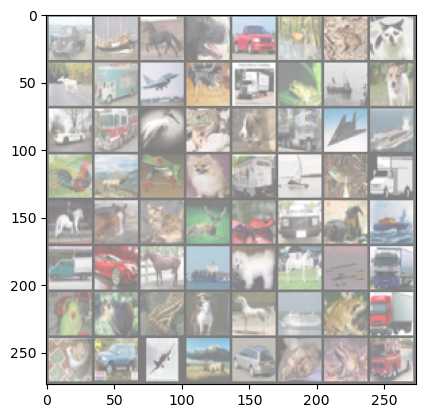

truck ship  horse dog   car   deer  frog  cat  


In [22]:
import torchvision

batch_size = 8
# 获取一个批次的图像和标签
images, labels = next(iter(dataloader))
# 定义 CIFAR-10 类别
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# 显示图像的函数
def imshow(img):
    img = img / 2 + 0.5  # 反规范化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 显示一个批次的图像
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 损失函数和优化器
使用二元交叉熵损失（BCEWithLogitsLoss）。
为生成器和判别器分别设置 Adam 优化器。
训练过程

In [23]:
criterion = nn.BCEWithLogitsLoss()
goptimizer = torch.optim.Adam(gnet.parameters(), lr=0.0002, betas=(0.5, 0.999))
doptimizer = torch.optim.Adam(dnet.parameters(), lr=0.0002, betas=(0.5, 0.999))

### 训练过程
迭代指定的次数（epoch_num）。
对每个批次的真实图像和生成的假图像计算损失。
更新判别器和生成器的权重。
每100个批次保存生成的图像。

Epoch index: 0, 20 epoches in total.
Batch index: 0, the batch size is 64.
Discriminator loss is: 1.3084664344787598, generator loss is: 4.209238052368164 
 Discriminator tells real images real ability: 0.6024653911590576 
 Discriminator tells fake images real ability: 0.50267/0.0173171
Epoch index: 0, 20 epoches in total.
Batch index: 100, the batch size is 64.
Discriminator loss is: 0.21530573070049286, generator loss is: 4.346060752868652 
 Discriminator tells real images real ability: 0.9230977892875671 
 Discriminator tells fake images real ability: 0.121168/0.0152757
Epoch index: 0, 20 epoches in total.
Batch index: 200, the batch size is 64.
Discriminator loss is: 0.5958294868469238, generator loss is: 2.469449281692505 
 Discriminator tells real images real ability: 0.630071222782135 
 Discriminator tells fake images real ability: 0.0488084/0.114509
Epoch index: 0, 20 epoches in total.
Batch index: 300, the batch size is 64.
Discriminator loss is: 1.126624584197998, generator l

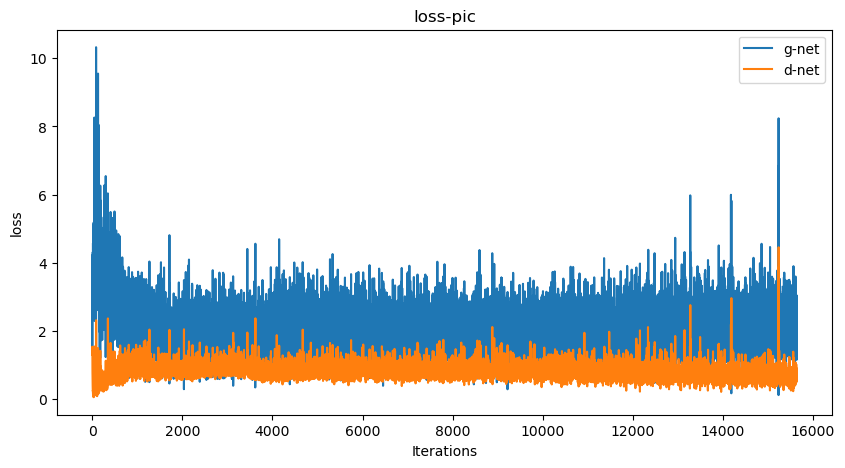

In [24]:
# 将模型移到GPU
dnet.to(device)
gnet.to(device)

batch_size = 64
fixed_noises = torch.randn(batch_size, latent_size, 1, 1, device=device)

# 初始化用于跟踪损失的列表
d_losses = []
g_losses = []

epoch_num = 20
for epoch in range(epoch_num):
    for batch_idx, data in enumerate(dataloader):
        real_images, _ = data
        real_images = real_images.to(device)  # 移到GPU
        batch_size = real_images.size(0)

        # 首先，用真实图像训练判别器
        labels = torch.ones(batch_size, device=device)
        preds = dnet(real_images)
        outputs = preds.reshape(-1)
        dloss_real = criterion(outputs, labels)
        dmean_real = outputs.sigmoid().mean()

        # 接着，用假图像训练判别器
        noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = gnet(noises)
        labels = torch.zeros(batch_size, device=device)
        fake = fake_images.detach()

        preds = dnet(fake)
        outputs = preds.view(-1)
        dloss_fake = criterion(outputs, labels)
        dmean_fake = outputs.sigmoid().mean()

        # 更新判别器
        dloss = dloss_real + dloss_fake
        dnet.zero_grad()
        dloss.backward()
        doptimizer.step()

        # 训练生成器
        labels = torch.ones(batch_size, device=device)
        preds = dnet(fake_images)
        outputs = preds.view(-1)
        gloss = criterion(outputs, labels)
        gmean_fake = outputs.sigmoid().mean()
        gnet.zero_grad()
        gloss.backward()
        goptimizer.step()

        # 记录损失
        d_losses.append(dloss.item())
        g_losses.append(gloss.item())

        if batch_idx % 100 == 0:
            fake = gnet(fixed_noises)
            save_image(fake, f'./GAN_saved/images_epoch{epoch:02d}_batch{batch_idx:03d}.png')

            print(f'Epoch index: {epoch}, {epoch_num} epoches in total.')
            print(f'Batch index: {batch_idx}, the batch size is {batch_size}.')
            print(f'Discriminator loss is: {dloss}, generator loss is: {gloss}', '\n',
                  f'Discriminator tells real images real ability: {dmean_real}', '\n',
                  f'Discriminator tells fake images real ability: {dmean_fake:g}/{gmean_fake:g}')
# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.title("loss-pic")
plt.plot(g_losses, label="g-net")
plt.plot(d_losses, label="d-net")
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

### 保存模型
将训练好的生成器和判别器模型保存到文件。

In [25]:
gnet_save_path = 'gnet.pt'
torch.save(gnet, gnet_save_path)

dnet_save_path = 'dnet.pt'
torch.save(dnet, dnet_save_path)

### 测试模型
如果已经有训练过的模型，可以直接加载并测试

In [26]:
gnet = torch.load(gnet_save_path)
gnet.eval()

dnet = torch.load(dnet_save_path)
dnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
)

### 生成图像
在训练后生成新的图像并保存。

In [28]:
for i in range(100):
    noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = gnet(noises).to(device)
    save_image(fake_images, f'./GAN_Generated_Images/{i}.png')

### CGAN的实现

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import numpy as np
from torchvision.datasets import CIFAR10
import torch.nn.init as init
import matplotlib.pyplot as plt
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ConditionalGenerator(nn.Module):
    def __init__(self, latent_size, n_g_feature, n_channel, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, latent_size)

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size * 2, 4 * n_g_feature, kernel_size=4, bias=False),
            nn.BatchNorm2d(4 * n_g_feature),
            nn.ReLU(),

            nn.ConvTranspose2d(4 * n_g_feature, 2 * n_g_feature, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2 * n_g_feature),
            nn.ReLU(),

            nn.ConvTranspose2d(2 * n_g_feature, n_g_feature, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_g_feature),
            nn.ReLU(),

            nn.ConvTranspose2d(n_g_feature, n_channel, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c.unsqueeze(2).unsqueeze(3)], 1)
        return self.main(x)


class ConditionalDiscriminator(nn.Module):
    def __init__(self, n_channel, n_d_feature, num_classes):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, n_channel * 32 * 32)

        self.main = nn.Sequential(
            nn.Conv2d(n_channel * 2, n_d_feature, kernel_size=4, stride=2, padding=1)
            ,
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_d_feature, 2 * n_d_feature, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2 * n_d_feature),
            nn.LeakyReLU(0.2),

            nn.Conv2d(2 * n_d_feature, 4 * n_d_feature, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4 * n_d_feature),
            nn.LeakyReLU(0.2),

            nn.Conv2d(4 * n_d_feature, 1, kernel_size=4)
        )

    def forward(self, x, labels):
        c = self.label_emb(labels).view(-1, n_channel, 32, 32)
        x = torch.cat([x, c], 1)
        return self.main(x)


dataset = CIFAR10(root='./CIFARdata', download=True, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# 模型参数
latent_size = 1024  # 假设潜在空间维度为100
n_channel = 3  # 图像通道数
n_g_feature = 64  # 生成器特征数
n_d_feature = 64  # 判别器特征数
num_classes = 1  # CIFAR10的类别数

# 创建生成器和判别器实例
netG = ConditionalGenerator(latent_size, n_g_feature, n_channel, num_classes).to(device)
netD = ConditionalDiscriminator(n_channel, n_d_feature, num_classes).to(device)


def weights_init(m):
    if type(m) in [nn.ConvTranspose2d, nn.Conv2d]:
        init.xavier_normal_(m.weight)
    elif type(m) == nn.BatchNorm2d:
        init.normal_(m.weight, 1.0, 0.02)
        init.constant_(m.bias, 0)


# 应用权重初始化
netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()

# 为生成器和判别器设置优化器
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.00000002, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.00000002, betas=(0.5, 0.999))

# 参数设置
batch_size = 64
fixed_noises = torch.randn(batch_size, latent_size, 1, 1)
fixed_labels = torch.randint(0, num_classes, (batch_size,))

# 初始化用于跟踪损失的列表
d_losses = []
g_losses = []

# 训练循环
epoch_num = 3
for epoch in range(epoch_num):
    for batch_idx, (real_images, real_labels) in enumerate(dataloader):
        current_batch_size = real_images.size(0)
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        # 为每个批次生成随机标签
        labels = torch.randint(0, num_classes, (current_batch_size,), device=device)

        # 训练判别器
        netD.zero_grad()
        real_images = real_images.to(device)
        labels = labels.to(device)
        outputs = netD(real_images, labels).view(-1, 1)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()
        D_x = outputs.sigmoid().mean()

        # 生成假图像
        noise = torch.randn(current_batch_size, latent_size, 1, 1, device=device)
        fake_images = netG(noise, labels)
        outputs = netD(fake_images.detach(), labels).view(-1, 1)
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        D_G_z1 = outputs.sigmoid().mean()

        # 更新判别器
        d_loss = d_loss_real + d_loss_fake
        optimizerD.step()

        # 训练生成器
        netG.zero_grad()
        outputs = netD(fake_images.detach(), labels).view(-1, 1)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        D_G_z2 = outputs.sigmoid().mean()
        optimizerG.step()

        # 记录损失
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if batch_idx % 100 == 0:
            print(
                f'Epoch [{epoch}/{epoch_num}] Batch {batch_idx}/{len(dataloader)} Loss D: {d_loss:.4f}, Loss G: {g_loss:.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

            # 保存图像
            with torch.no_grad():
                fake = netG(fixed_noises.to(device), fixed_labels.to(device)).detach().to(device)
                save_image(fake, f'./CGAN_saved/images_epoch{epoch:02d}_batch{batch_idx:03d}.png')

# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="Generator")
plt.plot(d_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 保存生成器和判别器
generator_save_path = 'cgan_generator.pt'
torch.save(netG.state_dict(), generator_save_path)

discriminator_save_path = 'cgan_discriminator.pt'
torch.save(netD.state_dict(), discriminator_save_path)

# 重新创建模型实例
netG = ConditionalGenerator(latent_size, n_g_feature, n_channel, num_classes)
netD = ConditionalDiscriminator(n_channel, n_d_feature, num_classes)

# 加载保存的状态字典
netG.load_state_dict(torch.load(generator_save_path))
netD.load_state_dict(torch.load(discriminator_save_path))

# 将模型设置为评估模式
netG.eval()
netD.eval()

# 生成图像以评估模型
with torch.no_grad():
    for i in range(100):
        # 生成随机噪声和随机标签
        noises = torch.randn(batch_size, latent_size, 1, 1)
        random_labels = torch.randint(0, num_classes, (batch_size,))

        # 生成图像
        fake_images = netG(noises, random_labels).detach().to(device)

        # 保存生成的图像
        save_image(fake_images, f'./CGAN_Generated_Images/{i}.png')
